<a href="https://colab.research.google.com/github/shamim-ice/SPEECH_ENHANCEMENT_MVDR_BEAMFORMING/blob/master/speechEnhancementBeamforming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

1.12.1+cu113
0.12.1+cu113


In [2]:
!pip3 install mir_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 8.9 MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.7-py3-none-any.whl size=100721 sha256=8b31ad56346bbee8bd0ec53963b028cefcdba7d0a36b3323aaeb15ee1fec624d
  Stored in directory: /root/.cache/pip/wheels/18/5a/46/d2527ff1fd975e1a793375e6ed763bfe4d3ea396b7cdc470eb
Successfully built mir-eval


In [3]:
!pip3 install pesq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pesq: filename=pesq-0.0.4-cp37-cp37m-linux_x86_64.whl size=214593 sha256=08eeb767022f122f384548205debadca92ce8bc6ed3b8e1c5b9232db4ae7f296
  Stored in directory: /root/.cache/pip/wheels/c5/3d/9c/542731f8357f7c82eb6ac2047cc5375f92c9a05b09a715aff6
Successfully built pesq


In [4]:
!pip3 install pystoi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7793 sha256=9c7a0eafddb8fce18c7efd3de273b9f5865624965a69f83ffd17bf5583e6e9f8
  Stored in directory: /root/.cache/pip/wheels/46/4a/ad/3ab460193ed0535430b4b1575f255aa6bae69df17453628e86
Successfully built pystoi


In [5]:
from pesq import pesq
from pystoi import stoi
import mir_eval

import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.utils import download_asset

In [6]:
SAMPLE_RATE = 16000
SAMPLE_CLEAN = download_asset("tutorial-assets/mvdr/clean_speech.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/mvdr/noise.wav")

  0%|          | 0.00/0.98M [00:00<?, ?B/s]

  0%|          | 0.00/1.95M [00:00<?, ?B/s]

In [8]:
def plot_spectrogram(stft, title="Spectrogram", xlim=None):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(spectrogram, cmap="viridis", vmin=-100, vmax=0, origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

In [9]:
def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

In [10]:
def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()

In [11]:
def generate_mixture(waveform_clean, waveform_noise, target_snr):
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    waveform_noise *= 10 ** (-(target_snr - current_snr) / 20)
    return waveform_clean + waveform_noise


def evaluate(estimate, reference):
    si_snr_score = si_snr(estimate, reference)
    (
        sdr,
        _,
        _,
        _,
    ) = mir_eval.separation.bss_eval_sources(reference.numpy(), estimate.numpy(), False)
    pesq_mix = pesq(SAMPLE_RATE, estimate[0].numpy(), reference[0].numpy(), "wb")
    stoi_mix = stoi(reference[0].numpy(), estimate[0].numpy(), SAMPLE_RATE, extended=False)
    print(f"SDR score: {sdr[0]}")
    print(f"Si-SNR score: {si_snr_score}")
    print(f"PESQ score: {pesq_mix}")
    print(f"STOI score: {stoi_mix}")

In [12]:
waveform_clean, sr = torchaudio.load(SAMPLE_CLEAN)
waveform_noise, sr2 = torchaudio.load(SAMPLE_NOISE)
assert sr == sr2 == SAMPLE_RATE
# The mixture waveform is a combination of clean and noise waveforms with a desired SNR.
target_snr = 3
waveform_mix = generate_mixture(waveform_clean, waveform_noise, target_snr)

In [13]:
waveform_mix = waveform_mix.to(torch.double)
waveform_clean = waveform_clean.to(torch.double)
waveform_noise = waveform_noise.to(torch.double)

In [14]:
N_FFT = 1024
N_HOP = 256
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)

stft_mix = stft(waveform_mix)
stft_clean = stft(waveform_clean)
stft_noise = stft(waveform_noise)

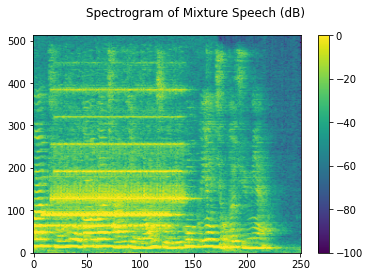

In [15]:
plot_spectrogram(stft_mix[0], "Spectrogram of Mixture Speech (dB)")

In [16]:
evaluate(waveform_mix[0:1], waveform_clean[0:1])

SDR score: 4.140362181778013
Si-SNR score: 4.104058905536078
PESQ score: 2.0084526538848877
STOI score: 0.7724339398714715


In [17]:
Audio(waveform_mix[0], rate=SAMPLE_RATE)

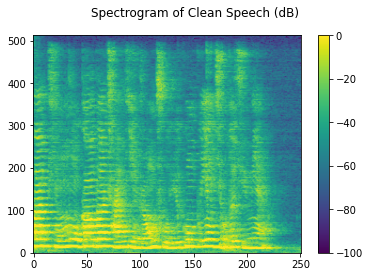

In [18]:
plot_spectrogram(stft_clean[0], "Spectrogram of Clean Speech (dB)")
Audio(waveform_clean[0], rate=SAMPLE_RATE)

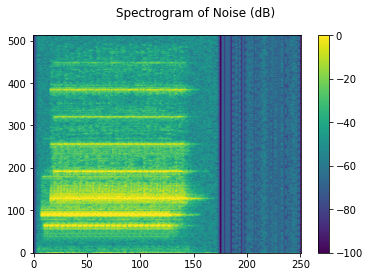

In [19]:
plot_spectrogram(stft_noise[0], "Spectrogram of Noise (dB)")
Audio(waveform_noise[0], rate=SAMPLE_RATE)